# Quantum Machine Learning for Quantum Many-Body Systems

## Motivation

Traditional machine learning models have successfully learned from accurately calculated molecular properties, significantly advancing the exploration of chemical space. This involves systematically navigating potential chemical compounds based on desired characteristics and predicting properties of new molecules through structural features. The emergence of quantum machine learning is expected to enable exploration in a broader materials space, accelerating the discovery of compounds with desired properties for more sustainable and efficient technologies.

Many-body systems refer to physical systems composed of a large number of interacting elements, often particles such as atoms or molecules. The behavior of these systems is governed by the principles of quantum mechanics, where the interactions between individual particles give rise to collective phenomena that can be highly complex and challenging to predict. Large-scale neural networks, successful in solving complex problems like image recognition, have been applied to study quantum many-body systems. However, directly applying classical algorithms to inherently quantum problems, where quantum states or processes are inputs, is challenging due to the extensive many-body Hilbert space.

In the realm of condensed matter physics, understanding the diverse phases of matter is crucial. These phases, such as topological or superconducting states, emerge from the collective quantum behavior of particles at ultra-low temperatures. Traditional methods of classifying these phases involve measuring global properties, often challenging due to the complexities of quantum systems. Quantum machine learning, however, employs algorithms designed to operate on quantum computers, enabling efficient analysis of these systems. By utilizing quantum neural networks, it becomes feasible to learn and classify different quantum phases based on observable features like magnetic fields and chemical potentials. This approach holds promise for unraveling the mysteries of quantum matter and can potentially revolutionize our ability to predict and engineer materials with unique and desirable properties for technological applications.

## Classifying topological and trivial phases in a superconducting system

### Topological and trivial phases
In condensed matter physics, the topological phase refers to a unique state of matter that exhibits non-local and robust quantum properties. These properties are protected against small perturbations. Topological phases are often characterized by nontrivial global properties of the system, such as nontrivial topology of the electronic wavefunctions or the existence of edge states. In contrast, a trivial phase is a conventional state of matter that does not exhibit the non-local and robust quantum properties characteristic of topological phases.

### Majorana modes
Majorana modes are special quasiparticle excitations that exist in certain condensed matter systems. They are their own antiparticles, meaning a Majorana fermion is identical to its own conjugate. In the context of superconductors, Majorana modes can emerge at the ends of a one-dimensional superconducting wire which exhibits a topological phase.

### Topological phase in a real system
We need three key ingredients to obtain a topological phase in a real engineered system.  First, we need to have a superconductor. Let us assume that our system is composed of a gapped superconductor such as Aluminium. Second, we need to induce spin-orbit coupling which can be induced by proximity coupling the semiconductor nano-wire. An example of that is InAs. Third, we need to apply an external magnetic field to the system.

<img src="MZM.png" alt="drawing" width="200"/>

Our system has two tuning knobs. We can tune the chemical potential, $\mu$ of the system by gating. We can also change the magnitude of the magnetic field, $B_z$. At certain critical values of the magnetic field, the system undergoes a topological phase transition. In the topological phase, Majorana modes appear at the ends of the wire. These Majorana modes are robust against local perturbations, making them interesting for potential applications in quantum computing. The condition to obtain a topological phase is $$B_z^2>\mu^2+\Delta^2$$ where $\Delta$ is the superconducting energy gap (order parameter).

## Problem statement
Based on the parameters, $B_z$ and $\mu$, we can tune the system into topological and trivial phase. By normalizing these parameters with respect to the superconducting energy gap, as $B_z/\Delta \rightarrow B_z$ and $\mu/\Delta \rightarrow \mu$, we redefine our variables.  Therefore, we get the criterion for topological phase as $$B_z^2>\mu^2+1.$$

Our dataset is composed of values corresponding to $B_z$ and $\mu$, now redefined in terms of $\Delta$ as mentioned above. These data points, along with the condition $B_z^2 > \mu^2 + 1$, are utilized for training a quantum neural network. The primary objective is to enable the quantum neural network to predict whether the system will exhibit a topological or trivial phase based on the input values of $B_z$ and $\mu$.

## Required packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

/var/folders/jw/9yfzbt590773902bgnsfd3c40000gn/T/ipykernel_24752/4206145224.py:7: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


## Simulator

In [25]:
qasm_sim = AerSimulator()

## Dataset

In [16]:
SEED=42
np.random.seed(SEED)
data_size=1000

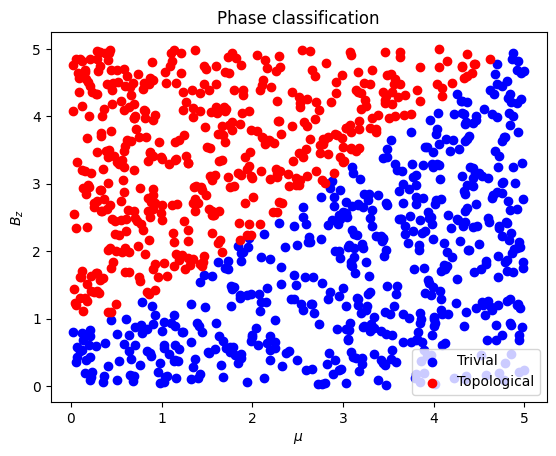

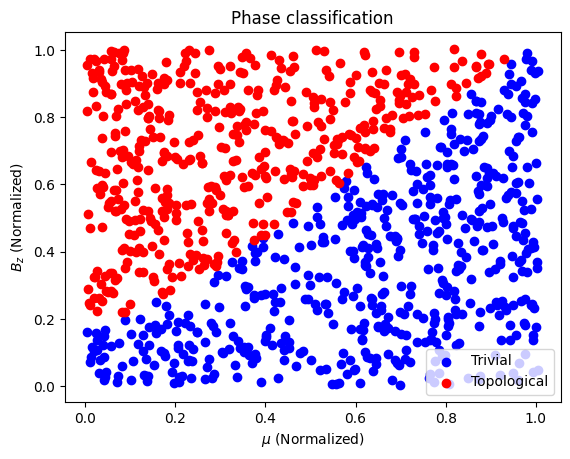

In [17]:
nvals=data_size
x=5*np.random.rand(nvals,2)
y=np.zeros(nvals)

mu_vals=x[:,0]
bz_vals=x[:,1]

num_classes = 2
num_features = 2

for i in range(nvals):
    if bz_vals[i]**2>mu_vals[i]**2+1:
        y[i]=1

x_blue = x[y==0]
x_red = x[y==1]

plt.figure()
plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="Trivial")
plt.scatter(x_red[:,0], x_red[:,1], c='r', label="Topological")
plt.title("Phase classification")
plt.xlabel('$\mu$')
plt.ylabel('$B_z$')
plt.legend()
plt.show()

#Normalization
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))
bz_norm=x[:,0]
mu_norm=x[:,1]

x_blue = x[y==0]
x_red = x[y==1]

plt.figure()
plt.scatter(x_blue[:,0], x_blue[:,1], c='b', label="Trivial")
plt.scatter(x_red[:,0], x_red[:,1], c='r', label="Topological")
plt.title("Phase classification")
plt.xlabel('$\mu$ (Normalized)')
plt.ylabel('$B_z$ (Normalized)')
plt.legend()
plt.show()

In [18]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 800
Test set size:  200
